In [1]:
import random
import cv2
import numpy as np
import pandas as pd
import glob
import tensorflow as tf
import os 

from PIL import Image
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import SGD, RMSprop
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from keras.applications import InceptionV3, VGG16, DenseNet201, MobileNetV2, ResNet152V2, InceptionResNetV2, NASNetLarge, Xception
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import matthews_corrcoef, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

Using TensorFlow backend.


In [ ]:
#Move train data to colab virtual machine to increase speed
!cp -r "/content/drive/My Drive/Dog_Whistle_Code/Data/Train/Train_images" "/content"

In [ ]:
#Move dev data to colab virtual machine to increase speed
!cp -r "/content/drive/My Drive/Dog_Whistle_Code/Data/Validation/Validation_images" "/content"

In [2]:
#Move test data to colab virtual machine to increase speed
!cp -r "/content/drive/My Drive/Dog_Whistle_Code/Data/Test/Test_images" "/content"

In [3]:
def metrics(labels, preds, argmax_needed: bool = False):
    """
    Returns the Matthew's correlation coefficient, accuracy rate, true positive rate, true negative rate, false positive rate, false negative rate, precission, recall, and f1 score
    
    labels: list of correct labels

    pred: list of model predictions
    """

    if argmax_needed == True:
        preds = np.argmax(preds, axis=1).flatten()

    mcc = matthews_corrcoef(labels, preds)
    acc = accuracy_score(labels, preds)
    cm = confusion_matrix(labels, preds)

    f1 = f1_score(labels, preds, average= "weighted")
    precision = precision_score(labels, preds, average= "weighted")
    recall = recall_score(labels, preds, average= "weighted")

    results = {
        "mcc": mcc,
        "acc": acc,
        "confusion_matrix": cm,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }
    
    return results, labels, preds

def image_model_saver(image_model, model_type, output_directory, training_dict, labels1, labels2, preds, results1, results2):
    """
    Saves Keras image model and other outputs

    image_model: Image model to be saved
    
    model_type (string): Name of model
    
    output_directory: Directory to folder to save file in

    training_dict: Dictionary of training and validation values 

    labels1: List of multimodal labels for test set

    labels2: List of unimodal labels for test set

    preds: List of model predictions after passed through argmax()

    results1: Dictionary of metrics on multimodal labels

    results2: Dictionary of metrics on uniimodal labels

    tokenizer: Tokenizer to be saved. Defaulted to None.
    """
    output_directory = os.path.join(output_directory, model_type)
    
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    os.chdir(output_directory)

    np.save(model_type+"_dogwhistle_train_results.npy", training_dict) #save training dict
    np.save(model_type+"_dogwhistle_test_results_multimodal.npy", results1) #save test metrics
    np.save(model_type+"_dogwhistle_test_results_unimodal.npy", results2) #save test metrics
    
    test_predictions = pd.DataFrame([labels1, labels2, preds]) #save predictions and labels
    test_predictions = test_predictions.T
    test_predictions = test_predictions.rename(columns={0: 'Multimodal Labels', 1: 'Unimodal Labels', 2: 'Predictions'})
    test_predictions.to_csv(model_type+"_dogwhistle_predictions.csv")

    image_model.save("image_model.h5") #save model

    return print("Saving complete.")

In [4]:
def fine_tune(base_model, train_directory, dev_directory, optimzer, scheduler, image_size: int, num_epochs: int=10, min_delta= 0, patience: int=10, batch_size: int=64, dropout: float=0.5):
    """
    Function for fine tuning pretrained CovNets

    base_model: Type of pre-trained model

    train_directory: Path to parent folder containing train images sub-divided into folders by label names

    dev_directory: Path to parent folder containing dev images sub-divided into folders by label names

    optimizer: Algorithim according to which values from the loss function should be back propogated

    scheduler: Callback determining learning rate decay

    image_size (int): Number of pixels in input dimensions (assumes square shape) 

    num_epochs (int): Number of passes through train data. Defaulted to 10.

    min_delta: Minimum reduction in val loss for early stopping

    patience (int): Number of epochs at min_delta before early stopping. Defaulted to 10.

    batch_size (int): Size of mini batches used in training. Defaulted to 64.

    dropout (int): Percentage of nodes turned off in final softmax layer. Defaulted to 0.5.

    """

    #Load data
    train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

    validation_datagen = ImageDataGenerator(rescale=1./255)

    
    train_generator = train_datagen.flow_from_directory(train_directory,
                                                        target_size=(image_size, image_size),
                                                        classes=["None", "Hateful", "Counter-speech", "Reclaimed"],
                                                        class_mode="categorical",
                                                        batch_size=batch_size,
                                                        shuffle=True,
                                                        seed=22)


    validation_generator = validation_datagen.flow_from_directory(dev_directory,
                                                                  target_size=(image_size, image_size),
                                                                  classes=["None", "Hateful", "Counter-speech", "Reclaimed"],
                                                                  class_mode="categorical",
                                                                  batch_size=batch_size,
                                                                  shuffle=True,
                                                                  seed=22)
                                                                
    #Add Classifier atop pre-trained model

    # global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # fully-connected layer
    x = Dense(1024, activation='relu')(x)
    x = Dropout(dropout)(x)
    # logistic layer
    predictions = Dense(4, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Train top 5% of pre-trained model layers with top layers
    for layer in model.layers[:int(len(model.layers) * 0.95)]:
        layer.trainable = False

    for layer in model.layers[int(len(model.layers) * 0.95):]:
        layer.trainable = True

    early_stop = EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=patience, verbose=1, mode='auto')
    model.compile(optimizer=optimzer, loss='categorical_crossentropy', metrics=['accuracy']) 
    history = model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=[early_stop, scheduler])
    
    train_dict = {"Train Accuracy": history.history['accuracy'], "Train Loss": history.history['loss'], "Val Accuracy": history.history['val_accuracy'], "Val Loss": history.history['val_loss'] }
    
    return model, train_dict


def test(trained_model, test_directory, image_size: int, batch_size: int=64):
    """
    Outputs metrics, predictions, and labels from image model

    trained_model: Trained image model

    test_directory: Path to parent folder containing test images sub-divided into folders by label names

    image_size (int): Number of pixels in input dimensions (assumes square shape)

    batch_size (int): Size of mini batches used in training. Defaulted to 64.
    """

    test_datagen = ImageDataGenerator(rescale=1./255)

    test_generator = test_datagen.flow_from_directory(test_directory,
                                                      target_size=(image_size, image_size),
                                                      classes=["None", "Hateful", "Counter-speech", "Reclaimed"],
                                                      class_mode="categorical",
                                                      batch_size=batch_size,
                                                      shuffle=False,
                                                      seed=22)

    label_list = []

    for i in range(len(test_generator)):
        values = np.argmax(test_generator[i][1], axis=1).flatten()
        label_list.extend(values)
    
    preds = trained_model.predict(test_generator)

    results, labels, predictions = metrics(label_list, preds, argmax_needed=True)

    return results, labels, predictions, test_generator

In [5]:
"""
InceptionResNet-V2 paper specifies...
optimizer = RMSProp
epsilon = 1.0
learning_rate =  0.045
exponential decay every 2 epochs at rate of 0.94
image size = (299, 299)

NASNet paper specifies... 
optimizer = RMSProp
epsilon = 1.0
learning_rate =  0.045
drop_out = 0.5
epochs = 20
exponential decay every 2 epochs at rate of 0.9999
image size = (331, 331)

Xception paper specifies... 
optimizer = SGD
learning_rate =  0.045
drop_out = 0.5
exponential decay every 2 epochs at rate of 0.94
Momentum: 0.9
image size = (299, 299)
"""

#Define shared hyperparameters
MIN_DELTA = 0.001
PATIENCE = 3
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 0.045
DROPOUT = 0.5
EPSILON = 1.0 
TRAIN_LEN = 3998

OUTPUT_DIR = "/content/drive/My Drive/Dog_Whistle_Code/Fine_Tuned_Models/Image"
TRAIN_PATH = "/content/Train_images"
DEV_PATH = "/content/Validation_images"
TEST_PATH_UNIMODAL = "/content/Test_images/Unimodal Labels"
TEST_PATH_MULTIMODAL = "/content/Test_images/Multimodal Labels"


#InceptionResNet-V2 Hyperparameters
IRN_IMAGE_SIZE = 299
IRN_OPTIMIZER = RMSprop(learning_rate = LEARNING_RATE, epsilon=EPSILON)

def IRN_decay(epoch, lr):
    epochs_drop = 2.0
    IRN_DECAY_RATE = 0.94
    lrate = lr * (IRN_DECAY_RATE**((1+epoch)/epochs_drop))
    return lrate

IRN_SCHEDULER = LearningRateScheduler(IRN_decay)


#NASNet Hyperparameters
NN_IMAGE_SIZE = 331
NN_OPTIMIZER = RMSprop(learning_rate= LEARNING_RATE, epsilon=EPSILON)

def NN_decay(epoch, lr):
    epochs_drop = 2.0
    NN_DECAY_RATE = 0.9999
    lrate = lr * (NN_DECAY_RATE**((1+epoch)/epochs_drop))
    return lrate

NN_SCHEDULER = LearningRateScheduler(NN_decay)


#Xception Hyperparametes
X_IMAGE_SIZE = 299
X_OPTIMIZER = SGD(lr= LEARNING_RATE, momentum=0.9)

def X_decay(epoch, lr):
    epochs_drop = 2.0
    X_DECAY_RATE = 0.94
    lrate = lr * (X_DECAY_RATE**((1+epoch)/epochs_drop))
    return lrate

X_SCHEDULER = LearningRateScheduler(X_decay)


No handles with labels found to put in legend.


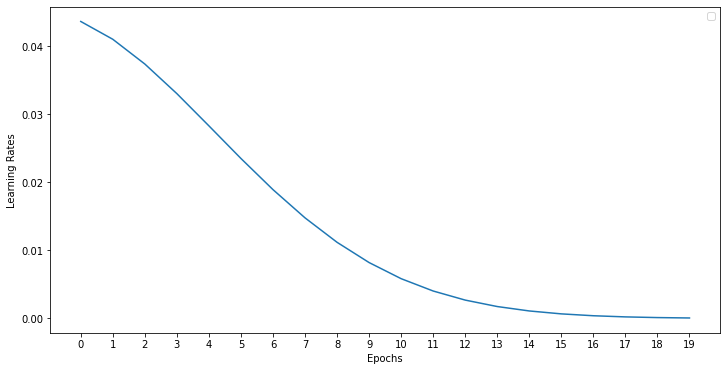

In [ ]:
#Visualize learning rate decay
# import matplotlib.pyplot as plt

# vals = []
# lr = 0.045
# for i in range(20):
#     val = step_decay(i, lr)
#     vals.append(val)
#     lr = val

# plt.rcParams["figure.figsize"] = (12,6)

# plt.plot(vals)

# plt.xlabel("Epochs")
# plt.ylabel("Learning Rates")
# plt.xticks(np.arange(20))
# plt.legend()

# #plt.savefig("learning_rate_decay.png",bbox_inches='tight')

### Run Models

In [ ]:
#Train and Test InceptionResNet-V2
model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(IRN_IMAGE_SIZE, IRN_IMAGE_SIZE, 3))
trained_model, train_dict = fine_tune(model, TRAIN_PATH, DEV_PATH, IRN_OPTIMIZER, IRN_SCHEDULER, IRN_IMAGE_SIZE, NUM_EPOCHS, MIN_DELTA, PATIENCE, BATCH_SIZE, DROPOUT)   
results1, labels1, predictions1, datagenerator1 = test(trained_model, TEST_PATH_MULTIMODAL, IRN_IMAGE_SIZE, BATCH_SIZE) 
results2, labels2, predictions2, datagenerator2 = test(trained_model, TEST_PATH_UNIMODAL, IRN_IMAGE_SIZE, BATCH_SIZE)
print(results1)
print(results2)
image_model_saver(trained_model, "InceptionResNetV2", OUTPUT_DIR, train_dict, labels1, labels2, predictions1, results1, results2)

Found 502 images belonging to 4 classes.


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Found 502 images belonging to 4 classes.
{'mcc': 0.14853090316382364, 'acc': 0.5338645418326693, 'confusion_matrix': array([[164,  97,   0,   7],
       [ 81, 102,   0,   2],
       [  8,   4,   0,   0],
       [ 24,  11,   0,   2]]), 'precision': 0.5051321174604282, 'recall': 0.5158596466494282, 'f1': 0.5158596466494282}
Saving complete.


In [ ]:
#Train and Test NASNet
model = NASNetLarge(weights='imagenet', include_top=False, input_shape=(NN_IMAGE_SIZE, NN_IMAGE_SIZE, 3))
trained_model, train_dict = fine_tune(model, TRAIN_PATH, DEV_PATH, NN_OPTIMIZER, NN_SCHEDULER, NN_IMAGE_SIZE, NUM_EPOCHS, MIN_DELTA, PATIENCE, BATCH_SIZE, DROPOUT)   
results1, labels1, predictions1, datagenerator1 = test(trained_model, TEST_PATH_MULTIMODAL, NN_IMAGE_SIZE, BATCH_SIZE) 
results2, labels2, predictions2, datagenerator2 = test(trained_model, TEST_PATH_UNIMODAL, NN_IMAGE_SIZE, BATCH_SIZE) 
print(results1)
print(results2)
image_model_saver(trained_model, "NASNet", OUTPUT_DIR, train_dict, labels1, labels2, predictions1, results1, results2)

343613440/343610240 [==============================] - 4s 0us/step
Found 3998 images belonging to 4 classes.
Found 500 images belonging to 4 classes.
Epoch 1/20
125/125 [==============================] - 447s 4s/step - loss: 0.7677 - accuracy: 0.7066 - val_loss: 1.0924 - val_accuracy: 0.7360
Epoch 2/20
125/125 [==============================] - 401s 3s/step - loss: 0.6820 - accuracy: 0.7376 - val_loss: 0.4869 - val_accuracy: 0.7160
Epoch 3/20
125/125 [==============================] - 401s 3s/step - loss: 0.6406 - accuracy: 0.7536 - val_loss: 0.7857 - val_accuracy: 0.6660
Epoch 4/20
125/125 [==============================] - 401s 3s/step - loss: 0.6092 - accuracy: 0.7664 - val_loss: 0.7318 - val_accuracy: 0.7300
Epoch 5/20
125/125 [==============================] - 401s 3s/step - loss: 0.5732 - accuracy: 0.7691 - val_loss: 0.6357 - val_accuracy: 0.7340
Epoch 00005: early stopping
Found 502 images belonging to 4 classes.


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Found 502 images belonging to 4 classes.
{'mcc': 0.20156034014285756, 'acc': 0.5856573705179283, 'confusion_matrix': array([[232,  34,   0,   2],
       [124,  61,   0,   0],
       [ 11,   1,   0,   0],
       [ 33,   3,   0,   1]]), 'precision': 0.5612813392893075, 'recall': 0.5328237442403785, 'f1': 0.5328237442403785}
Saving complete.


In [ ]:
#Train and Test Xception
model = Xception(weights='imagenet', include_top=False, input_shape=(X_IMAGE_SIZE, X_IMAGE_SIZE, 3))
trained_model, train_dict = fine_tune(model, TRAIN_PATH, DEV_PATH, X_OPTIMIZER, X_SCHEDULER, X_IMAGE_SIZE, NUM_EPOCHS, MIN_DELTA, PATIENCE, BATCH_SIZE, DROPOUT)   
results1, labels1, predictions1, datagenerator1 = test(trained_model, TEST_PATH_MULTIMODAL, X_IMAGE_SIZE, BATCH_SIZE) 
results2, labels2, predictions2, datagenerator2 = test(trained_model, TEST_PATH_UNIMODAL, X_IMAGE_SIZE, BATCH_SIZE)
print(results1)
print(results2)
image_model_saver(trained_model, "Xception", OUTPUT_DIR, train_dict, labels1, labels2, predictions1, results1, results2)

83689472/83683744 [==============================] - 1s 0us/step
Found 3998 images belonging to 4 classes.
Found 500 images belonging to 4 classes.
Epoch 1/20
125/125 [==============================] - 165s 1s/step - loss: 0.8139 - accuracy: 0.7051 - val_loss: 1.4008 - val_accuracy: 0.7600
Epoch 2/20
125/125 [==============================] - 148s 1s/step - loss: 0.7101 - accuracy: 0.7296 - val_loss: 0.6622 - val_accuracy: 0.7220
Epoch 3/20
125/125 [==============================] - 149s 1s/step - loss: 0.6823 - accuracy: 0.7424 - val_loss: 0.9263 - val_accuracy: 0.7080
Epoch 4/20
125/125 [==============================] - 150s 1s/step - loss: 0.6385 - accuracy: 0.7556 - val_loss: 0.7307 - val_accuracy: 0.7100
Epoch 5/20
125/125 [==============================] - 149s 1s/step - loss: 0.5989 - accuracy: 0.7696 - val_loss: 0.7218 - val_accuracy: 0.7460
Epoch 00005: early stopping
Found 502 images belonging to 4 classes.


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Found 502 images belonging to 4 classes.
{'mcc': 0.24124970097295248, 'acc': 0.603585657370518, 'confusion_matrix': array([[241,  27,   0,   0],
       [123,  62,   0,   0],
       [ 10,   2,   0,   0],
       [ 35,   2,   0,   0]]), 'precision': 0.5602593700178908, 'recall': 0.5444710854042994, 'f1': 0.5444710854042994}
{'mcc': 0.2893186546822142, 'acc': 0.7171314741035857, 'confusion_matrix': array([[309,  39,   0,   0],
       [ 70,  51,   0,   0],
       [  9,   1,   0,   0],
       [ 21,   2,   0,   0]]), 'precision': 0.655914868799901, 'recall': 0.6808232938196227, 'f1': 0.6808232938196227}
Saving complete.


### Exract Image Labels

In [397]:
from keras.models import load_model

#Train and Test Xception
ImageExtractor = load_model('/content/drive/My Drive/Dog_Whistle_Code/Fine_Tuned_Models/Image/Xception/image_model.h5') #using pre-trained Xception

results1, labels1, predictions1, test_generator1 = test(ImageExtractor, TEST_PATH_MULTIMODAL, X_IMAGE_SIZE, BATCH_SIZE) 
results2, labels2, predictions2, test_generator2 = test(ImageExtractor, TEST_PATH_UNIMODAL, X_IMAGE_SIZE, BATCH_SIZE)

Found 502 images belonging to 4 classes.


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Found 502 images belonging to 4 classes.


In [401]:
def id_extractor(test_generator):
    """
    test_generator: Generator object from Keras flow_from_directory()
    """

    ids = []

    for i in test_generator.filenames:
        id_label = i.split("/")[1]
        id_label = id_label.split(".")[0]
        ids.append(int(id_label))

    return ids

# Get label lists
ids1 = id_extractor(test_generator1)
ids2 = id_extractor(test_generator2)

In [402]:
# Create multimodal DF
test_predictions1 = pd.DataFrame([ids1, labels1, predictions1]) 
test_predictions1 = test_predictions1.T
test_predictions1 = test_predictions1.rename(columns={0: 'image_number', 1: 'Multimodal Labels', 2: 'Predictions_multimodal'})

# Create unimodal DF
test_predictions2 = pd.DataFrame([ids2, labels2, predictions2]) 
test_predictions2 = test_predictions2.T
test_predictions2 = test_predictions2.rename(columns={0: 'image_number', 1: 'Unimodal Labels', 2: 'Predictions_unimodal'})

# Merge and Save DFs
test_predictions = test_predictions1.merge(test_predictions2, on = "image_number")
test_predictions.to_csv("/content/drive/My Drive/Dog_Whistle_Code/Fine_Tuned_Models/Image/Xception/Xception_dogwhistle_predictions.csv")

In [403]:
# Check that values are the same
print(f1_score(test_predictions["Multimodal Labels"].values.tolist(), test_predictions["Predictions_multimodal"].values.tolist(), average = 'weighted'))
print(f1_score(test_predictions["Unimodal Labels"].values.tolist(), test_predictions["Predictions_unimodal"].values.tolist(), average = 'weighted'))

0.5444710854042994
0.6808232938196227
